# Module 02

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from msctools.dsp import decorate

# Non-periodic signals

The signals we have worked with so far are periodic, which means that
they repeat forever. It also means that the frequency components they
contain do not change over time. In this chapter, we consider
non-periodic signals, whose frequency components *do* change over time.
In other words, pretty much all sound signals.

## Linear chirp

<img src="../figs/PNG/chirp3.pdf-1.png" alt="image" width="70%" height="auto">

We'll start with a **chirp**, which is a signal with variable frequency.
`thinkdsp` provides a Signal called Chirp that makes a sinusoid that
sweeps linearly through a range of frequencies.

Here's an example that sweeps from 220 to 880 Hz, which is two octaves
from A3 to A5:

    signal = thinkdsp.Chirp(start=220, end=880)
    wave = signal.make_wave()

The figure shows segments of this wave near the beginning, middle, and end. It's
clear that the frequency is increasing.

Before we go on, let's see how Chirp is implemented. Here is the class
definition:

    class Chirp(Signal):

        def __init__(self, start=440, end=880, amp=1.0):
            self.start = start
            self.end = end
            self.amp = amp

`start` and `end` are the frequencies, in Hz, at the start and end of
the chirp. `amp` is amplitude.

Here is the function that evaluates the signal:

        def evaluate(self, ts):
            freqs = np.linspace(self.start, self.end, len(ts))
            dts = np.diff(ts, prepend=0)
            dphis = PI2 * freqs * dts
            phases = np.cumsum(dphis)
            ys = self.amp * np.cos(phases)
            return ys

`ts` is the sequence of points in time where the signal should be
evaluated; to keep this function simple, I assume they are
equally-spaced.

To compute the frequency at each point in time, I use `np.linspace`,
which returns a NumPy array of $n$ values between `start` and `end`.

`np.diff` computes the difference between adjacent elements of `ts`,
returning the length of each interval in seconds. If the elements of
`ts` are equally spaced, the `dts` are all the same.

The next step is to figure out how much the phase changes during each
interval. In Section [2.7](#sigobs){reference-type="ref"
reference="sigobs"} we saw that when frequency is constant, the phase,
$\phi$, increases linearly over time: $$\phi = 2 \pi f t$$ When
frequency is a function of time, the *change* in phase during a short
time interval, $\Delta t$ is: $$\Delta \phi = 2 \pi f(t) \Delta t$$ In
Python, since `freqs` contains $f(t)$ and `dts` contains the time
intervals, we can write

    dphis = PI2 * freqs * dts

Now, since `dphis` contains the changes in phase, we can get the total
phase at each timestep by adding up the changes:

    phases = np.cumsum(dphis)
    phases = np.insert(phases, 0, 0)

`np.cumsum` computes the cumulative sum, which is almost what we want,
but it doesn't start at 0. So I use `np.insert` to add a 0 at the
beginning.

The result is a NumPy array where the `i`th element contains the sum of
the first `i` terms from `dphis`; that is, the total phase at the end of
the `i`th interval. Finally, `np.cos` computes the amplitude of the wave
as a function of phase (remember that phase is expressed in radians).

If you know calculus, you might notice that the limit as $\Delta t$ gets
small is $$d\phi = 2 \pi f(t) dt$$ Dividing through by $dt$ yields
$$\frac{d\phi}{dt} = 2 \pi f(t)$$ In other words, frequency is the
derivative of phase. Conversely, phase is the integral of frequency.
When we used `cumsum` to go from frequency to phase, we were
approximating integration.

In [12]:
from thinkdsp import Chirp

signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

ModuleNotFoundError: No module named 'thinkdsp'

Here's what the waveform looks like near the beginning.

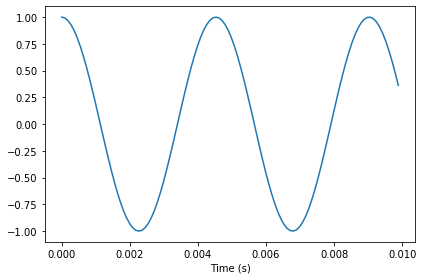

In [ ]:
wave1.segment(start=0, duration=0.01).plot()
decorate(xlabel='Time (s)')

And near the end.

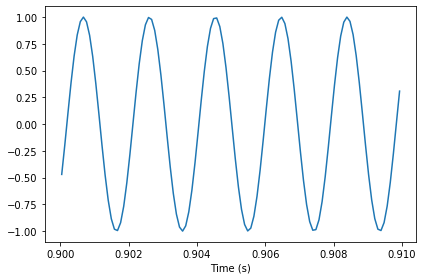

In [ ]:
wave1.segment(start=0.9, duration=0.01).plot()
decorate(xlabel='Time (s)')

## Exponential chirp

When you listen to this chirp, you might notice that the pitch rises
quickly at first and then slows down. The chirp spans two octaves, but
it only takes 2/3 s to span the first octave, and twice as long to span
the second.

The reason is that our perception of pitch depends on the logarithm of
frequency. As a result, the **interval** we hear between two notes
depends on the *ratio* of their frequencies, not the difference.
"Interval" is the musical term for the perceived difference between two
pitches.

For example, an octave is an interval where the ratio of two pitches is
2. So the interval from 220 to 440 is one octave and the interval from
440 to 880 is also one octave. The difference in frequency is bigger,
but the ratio is the same.

As a result, if frequency increases linearly, as in a linear chirp, the
perceived pitch increases logarithmically.

If you want the perceived pitch to increase linearly, the frequency has
to increase exponentially. A signal with that shape is called an
**exponential chirp**.

Here's the code that makes one:

    class ExpoChirp(Chirp):

        def evaluate(self, ts):
            start, end = np.log10(self.start), np.log10(self.end)
            freqs = np.logspace(start, end, len(ts)-1)
            return self._evaluate(ts, freqs)

Instead of `np.linspace`, this version of evaluate uses `np.logspace`,
which creates a series of frequencies whose logarithms are equally
spaced, which means that they increase exponentially.

That's it; everything else is the same as Chirp. Here's the code that
makes one:

        signal = thinkdsp.ExpoChirp(start=220, end=880)
        wave = signal.make_wave(duration=1)

You can listen to these examples in `chap03.ipynb` and compare the
linear and exponential chirps.

Here's an exponential chirp with the same frequency range and duration.

In [ ]:
np.linspace?


Signature:      
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Call signature:  np.linspace(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function linspace at 0x1059f5fc0>
File:            ~/anaconda3/envs/compmus/lib/python3.10/site-packages/numpy/core/function_base.py
Docstring:      
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

.. versionchanged:: 1.20.0
    Values are rounded towards ``-inf`` instead of ``0`` when an
    integer ``dtype`` is specified. The old behavior can
    still be obtained with ``np.linspace(start, stop, num).astype(int)``

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The e

In [ ]:
t = np.linspace(start= 0,stop= 100, num= 5)
print(t)

[  0.  25.  50.  75. 100.]


In [15]:
    class ExpoChirp(Chirp):

        def evaluate(self, ts):
            start, end = np.log10(self.start), np.log10(self.end)
            freqs = np.logspace(start, end, len(ts)-1)
            return self._evaluate(ts, freqs)

NameError: name 'Chirp' is not defined

In [16]:
from thinkdsp import ExpoChirp

signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

ModuleNotFoundError: No module named 'thinkdsp'

## Spectrum of a chirp

<!-- <img src="../figs/PNG/chirp1.pdf-1.png" alt="image" width="50%" height="auto"> -->

What do you think happens if you compute the spectrum of a chirp? Here's
an example that constructs a one-second, one-octave chirp and its
spectrum:

In [17]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()
spectrum.plot(high=700)

NameError: name 'Chirp' is not defined

The spectrum has components at every frequency from
220 to 440 Hz.

The spectrum is approximately flat between 220 and 440 Hz, which
indicates that the signal spends equal time at each frequency in this
range. Based on that observation, you should be able to guess what the
spectrum of an exponential chirp looks like.

The spectrum gives hints about the structure of the signal, but it
obscures the relationship between frequency and time. For example, we
cannot tell by looking at this spectrum whether the frequency went up or
down, or both.

## Spectrogram

<!-- <img src="../figs/PNG/chirp2.pdf-1.png" alt="image" width="50%" height="auto"> -->

To recover the relationship between frequency and time, we can break the
chirp into segments and plot the spectrum of each segment. The result is
called a **short-time Fourier transform** (STFT).

There are several ways to visualize a STFT, but the most common is a
**spectrogram**, which shows time on the x-axis and frequency on the
y-axis. Each column in the spectrogram shows the spectrum of a short
segment, using color or grayscale to represent amplitude.

As an example, I'll compute the spectrogram of this chirp:

In [ ]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)

`Wave` provides `make_spectrogram`, which returns a `Spectrogram`
object:

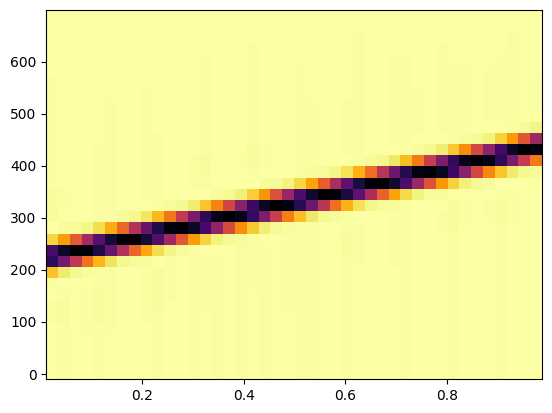

In [ ]:
spectrogram = wave.make_spectrogram(seg_length=512)
spectrogram.plot(high=700)

`seg_length` is the number of samples in each segment. I chose 512
because FFT is most efficient when the number of samples is a power of
2.

The figure
shows the result. The x-axis shows time from 0 to 1 seconds. The y-axis
shows frequency from 0 to 700 Hz. I cut off the top part of the
spectrogram; the full range goes to 5512.5 Hz, which is half of the
framerate.

The spectrogram shows clearly that frequency increases linearly over
time. Similarly, in the spectrogram of an exponential chirp, we can see
the shape of the exponential curve.

However, notice that the peak in each column is blurred across 2--3
cells. This blurring reflects the limited resolution of the spectrogram.

## The Gabor limit

The **time resolution** of the spectrogram is the duration of the
segments, which corresponds to the width of the cells in the
spectrogram. Since each segment is 512 frames, and there are 11,025
frames per second, the duration of each segment is about 0.046 seconds.

The **frequency resolution** is the frequency range between elements in
the spectrum, which corresponds to the height of the cells. With 512
frames, we get 256 frequency components over a range from 0 to 5512.5
Hz, so the range between components is 21.6 Hz.

More generally, if $n$ is the segment length, the spectrum contains
$n/2$ components. If the framerate is $r$, the maximum frequency in the
spectrum is $r/2$. So the time resolution is $n/r$ and the frequency
resolution is $$\frac{r/2}{n/2}$$ which is $r/n$.

Ideally we would like time resolution to be small, so we can see rapid
changes in frequency. And we would like frequency resolution to be small
so we can see small changes in frequency. But you can't have both.
Notice that time resolution, $n/r$, is the inverse of frequency
resolution, $r/n$. So if one gets smaller, the other gets bigger.

For example, if you double the segment length, you cut frequency
resolution in half (which is good), but you double time resolution
(which is bad). Even increasing the framerate doesn't help. You get more
samples, but the range of frequencies increases at the same time.

This tradeoff is called the **Gabor limit** and it is a fundamental
limitation of this kind of time-frequency analysis.

In [ ]:
def plot_spectrogram(wave, seg_length):
    """
    """
    spectrogram = wave.make_spectrogram(seg_length)
    print('Time resolution (s)', spectrogram.time_res)
    print('Frequency resolution (Hz)', spectrogram.freq_res)
    spectrogram.plot(high=700)
    decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Time resolution (s) 0.046439909297052155
Frequency resolution (Hz) 21.533203125


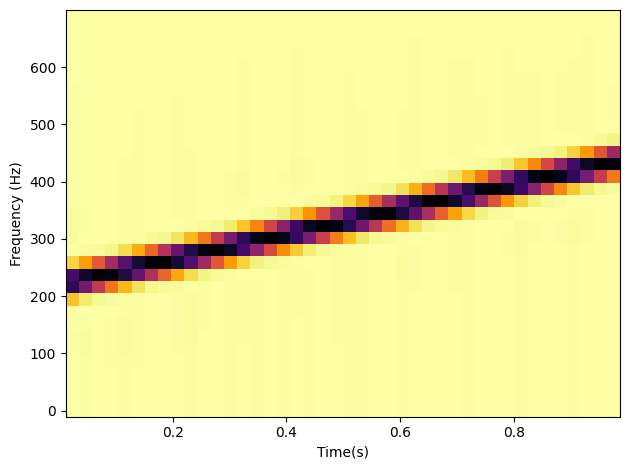

In [ ]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
plot_spectrogram(wave, 512)

Time resolution (s) 0.09287981859410431
Frequency resolution (Hz) 10.7666015625


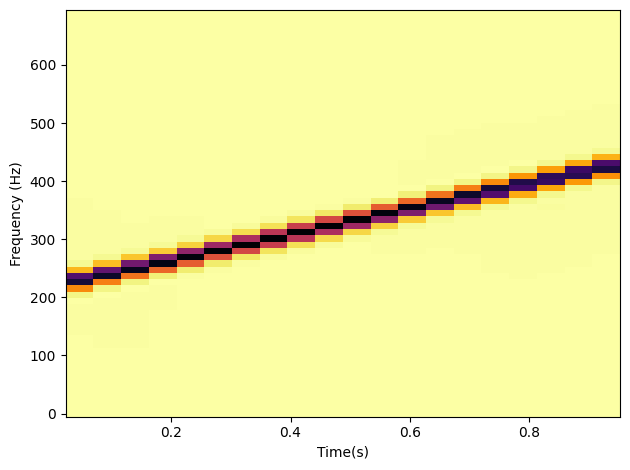

In [ ]:
plot_spectrogram(wave, 1024)

Time resolution (s) 0.02394557823129252
Frequency resolution (Hz) 41.76136363636363


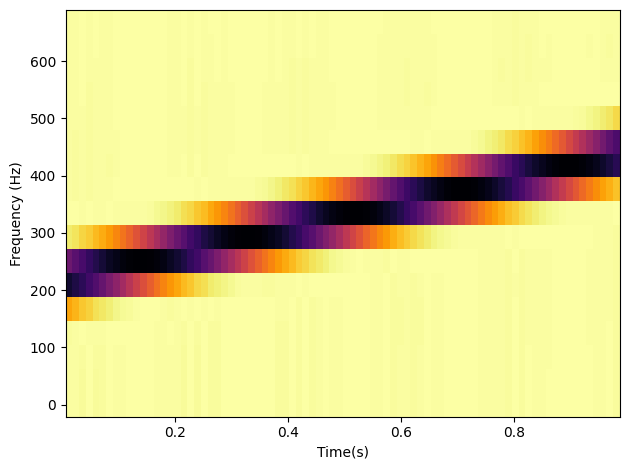

In [ ]:
plot_spectrogram(wave, 264)

## Leakage

<img src="../figs/PNG/windowing1.pdf-1.png" alt="image" width="50%" height="auto">

In order to explain how `make_spectrogram` works, I have to explain
windowing; and in order to explain windowing, I have to show you the
problem it is meant to address, which is leakage.

The Discrete Fourier Transform (DFT), which we use to compute Spectrums,
treats waves as if they are periodic; that is, it assumes that the
finite segment it operates on is a complete period from an infinite
signal that repeats over all time. In practice, this assumption is often
false, which creates problems.

One common problem is discontinuity at the beginning and end of the
segment. Because DFT assumes that the signal is periodic, it implicitly
connects the end of the segment back to the beginning to make a loop. If
the end does not connect smoothly to the beginning, the discontinuity
creates additional frequency components in the segment that are not in
the signal.

As an example, let's start with a sine signal that contains only one
frequency component at 440 Hz.

        signal = thinkdsp.SinSignal(freq=440)

If we select a segment that happens to be an integer multiple of the
period, the end of the segment connects smoothly with the beginning, and
DFT behaves well.

        duration = signal.period * 30
        wave = signal.make_wave(duration)
        spectrum = wave.make_spectrum()

Left panel shows the result. As expected, there
is a single peak at 440 Hz.

But if the duration is not a multiple of the period, bad things happen.
With `duration = signal.period * 30.25`, the signal starts at 0 and ends
at 1.

Figure (middle) shows the spectrum of this segment.
Again, the peak is at 440 Hz, but now there are additional components
spread out from 240 to 640 Hz. This spread is called **spectral
leakage**, because some of the energy that is actually at the
fundamental frequency leaks into other frequencies.

In this example, leakage happens because we are using DFT on a segment
that becomes discontinuous when we treat it as periodic.

In [ ]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)

If the duration is an integer multiple of the period, the beginning and end of the segment line up, and we get minimal leakage.

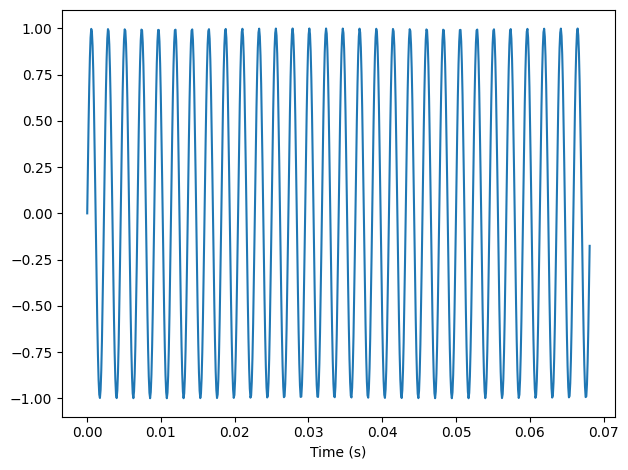

In [ ]:
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

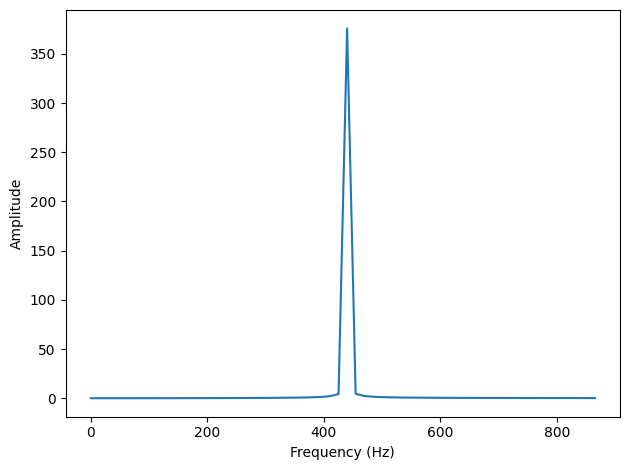

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

If the duration is not a multiple of a period, the leakage is pretty bad.

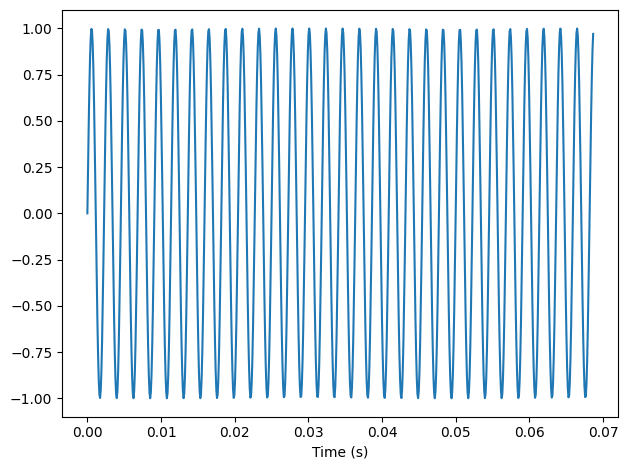

In [ ]:
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

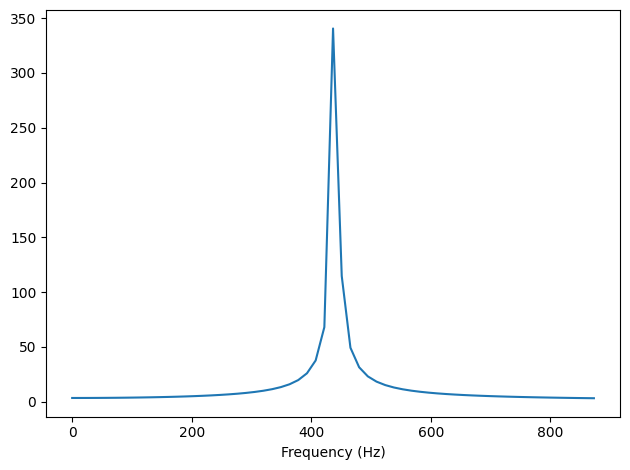

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

## Windowing

<img src="../figs/PNG/windowing2.pdf-1.png" alt="image" width="50%" height="auto">

We can reduce leakage by smoothing out the discontinuity between the
beginning and end of the segment, and one way to do that is
**windowing**.

A "window" is a function designed to transform a non-periodic segment
into something that can pass for periodic.

(top) shows a segment where the end does not
connect smoothly to the beginning.

(middle) shows a "Hamming window", one of
the more common window functions. No window function is perfect, but
some can be shown to be optimal for different applications, and Hamming
is a good, all-purpose window.

(bottom) shows the result of multiplying the
window by the original signal. Where the window is close to 1, the
signal is unchanged. Where the window is close to 0, the signal is
attenuated. Because the window tapers at both ends, the end of the
segment connects smoothly to the beginning.

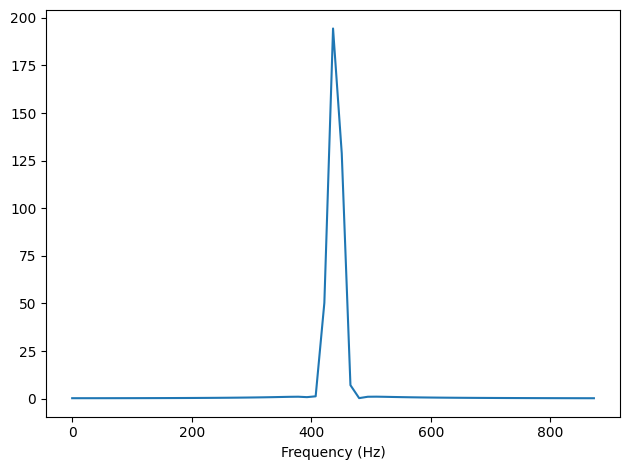

In [ ]:
#Windowing helps (but notice that it reduces the total energy).

wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

Here's what the code looks like. `Wave` provides `window`, which applies
a Hamming window:

    #class Wave:
        def window(self, window):
            self.ys *= window

And NumPy provides `hamming`, which computes a Hamming window with a
given length:

    window = np.hamming(len(wave))
    wave.window(window)

NumPy provides functions to compute other window functions, including
`bartlett`, `blackman`, `hanning`, and `kaiser`. One of the exercises at
the end of this chapter asks you to experiment with these other windows.

## Implementing spectrograms

<img src="../figs/PNG/windowing3.pdf-1.png" alt="image" width="50%" height="auto">

Now that we understand windowing, we can understand the implementation
of spectrogram. Here is the `Wave` method that computes spectrograms:

    #class Wave:
        def make_spectrogram(self, seg_length):
            window = np.hamming(seg_length)
            i, j = 0, seg_length
            step = seg_length / 2

            spec_map = {}

            while j < len(self.ys):
                segment = self.slice(i, j)
                segment.window(window)

                t = (segment.start + segment.end) / 2
                spec_map[t] = segment.make_spectrum()

                i += step
                j += step

            return Spectrogram(spec_map, seg_length)

This is the longest function in the book, so if you can handle this, you
can handle anything.

The parameter, `self`, is a Wave object. `seg_length` is the number of
samples in each segment.

`window` is a Hamming window with the same length as the segments.

`i` and `j` are the slice indices that select segments from the wave.
`step` is the offset between segments. Since ` step` is half of
`seg_length`, the segments overlap by half.
Figure [4.6](#fig.windowing3){reference-type="ref"
reference="fig.windowing3"} shows what these overlapping windows look
like.

`spec_map` is a dictionary that maps from a timestamp to a Spectrum.

Inside the while loop, we select a slice from the wave and apply the
window; then we construct a Spectrum object and add it to `spec_map`.
The nominal time of each segment, `t`, is the midpoint.

Then we advance `i` and `j`, and continue as long as `j` doesn't go past
the end of the Wave.

Finally, the method constructs and returns a Spectrogram. Here is the
definition of Spectrogram:

    class Spectrogram(object):
        def __init__(self, spec_map, seg_length):
            self.spec_map = spec_map
            self.seg_length = seg_length

Like many init methods, this one just stores the parameters as
attributes.

`Spectrogram` provides `plot`, which generates a pseudocolor plot with
time along the x-axis and frequency along the y-axis.

And that's how Spectrograms are implemented.

## Exercises part 1


**Exercise 1**. *In the leakage example, try replacing the Hamming window with one of
the other windows provided by NumPy, and see what effect they have on
leakage. See
<http://docs.scipy.org/doc/numpy/reference/routines.window.html>*


**Exercise 2**. *Write a class called `SawtoothChirp` that extends
`Chirp` and overrides `evaluate` to generate a sawtooth waveform with
frequency that increases (or decreases) linearly.*

*Hint: combine the evaluate functions from `Chirp` and
`SawtoothSignal`.*

*Draw a sketch of what you think the spectrogram of this signal looks
like, and then plot it. The effect of aliasing should be visually
apparent, and if you listen carefully, you can hear it.*

**Exercise 3**. *Make a sawtooth chirp that sweeps from 2500 to 3000
Hz, then use it to make a wave with duration 1 s and framerate 20 kHz.
Draw a sketch of what you think the spectrum will look like. Then plot
the spectrum and see if you got it right.*

**Exercise 4**. *In musical terminology, a "glissando" is a note that
slides from one pitch to another, so it is similar to a chirp.*

*Find or make a recording of a glissando and plot a spectrogram of the
first few seconds. One suggestion: George Gershwin's *Rhapsody in Blue*
starts with a famous clarinet glissando, which you can download from
<http://archive.org/details/rhapblue11924>.*

**Exercise 5**. *A trombone player can play a glissando by extending
the trombone slide while blowing continuously. As the slide extends, the
total length of the tube gets longer, and the resulting pitch is
inversely proportional to length.*

*Assuming that the player moves the slide at a constant speed, how does
frequency vary with time?*

*Write a class called `TromboneGliss` that extends `Chirp` and provides
`evaluate`. Make a wave that simulates a trombone glissando from C3 up
to F3 and back down to C3. C3 is 262 Hz; F3 is 349 Hz.*

*Plot a spectrogram of the resulting wave. Is a trombone glissando more
like a linear or exponential chirp?*

**Exercise 6**. *Make or find a recording of a series of vowel sounds
and look at the spectrogram. Can you identify different vowels?*


# Noise

In [ ]:
np.random.seed(17)

The simplest noise to generate is uncorrelated uniform (UU) noise:

## Uncorrelated noise

<img src="../figs/PNG/whitenoise0.pdf-1.png" alt="image" width="50%" height="auto">

The simplest way to understand noise is to generate it, and the simplest
kind to generate is uncorrelated uniform noise (UU noise). "Uniform"
means the signal contains random values from a uniform distribution;
that is, every value in the range is equally likely. "Uncorrelated"
means that the values are independent; that is, knowing one value
provides no information about the others.

Here's a class that represents UU noise:

    class UncorrelatedUniformNoise(_Noise):

        def evaluate(self, ts):
            ys = np.random.uniform(-self.amp, self.amp, len(ts))
            return ys

`UncorrelatedUniformNoise` inherits from `_Noise`, which inherits from
`Signal`.

As usual, the evaluate function takes `ts`, the times when the signal
should be evaluated. It uses `np.random.uniform`, which generates values
from a uniform distribution. In this example, the values are in the
range between `-amp` to `amp`.

In [ ]:
from thinkdsp import UncorrelatedUniformNoise

signal = UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

Here's what a segment of it looks like:

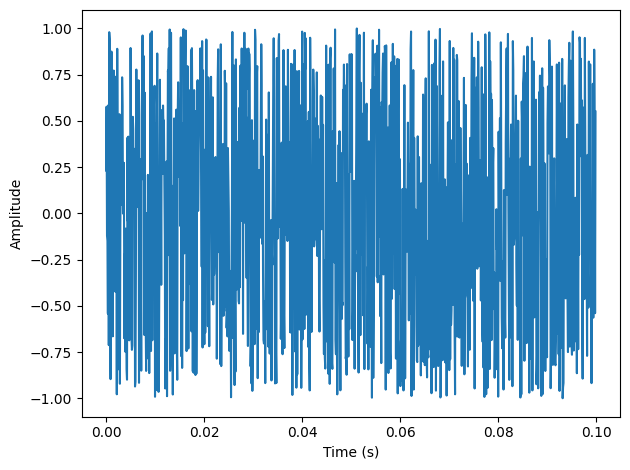

In [ ]:
segment = wave.segment(duration=0.1)
segment.plot()
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

Now let's take a look at the spectrum:

    spectrum = wave.make_spectrum()
    spectrum.plot_power()

`Spectrum.plot_power` is similar to `Spectrum.plot`, except that it
plots power instead of amplitude. Power is the square of amplitude. I am
switching from amplitude to power in this chapter because it is more
conventional in the context of noise.


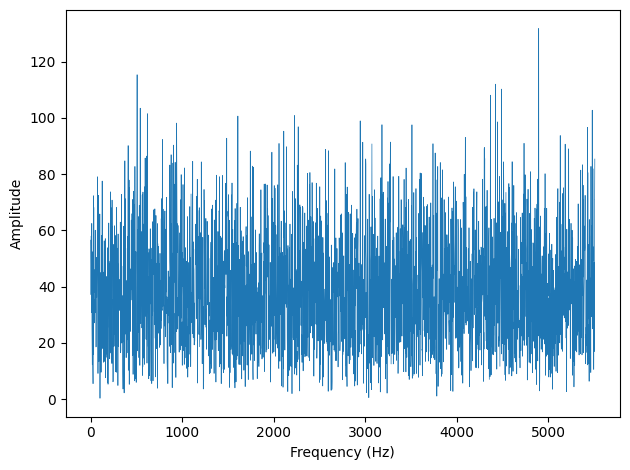

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

Like the signal, the
spectrum looks pretty random. In fact, it *is* random, but we have to be
more precise about the word "random". There are at least three things we
might like to know about a noise signal or its spectrum:

-   Distribution: The distribution of a random signal is the set of
    possible values and their probabilities. For example, in the uniform
    noise signal, the set of values is the range from -1 to 1, and all
    values have the same probability. An alternative is **Gaussian
    noise**, where the set of values is the range from negative to
    positive infinity, but values near 0 are the most likely, with
    probability that drops off according to the Gaussian or "bell"
    curve.

-   Correlation: Is each value in the signal independent of the others,
    or are there dependencies between them? In UU noise, the values are
    independent. An alternative is **Brownian noise**, where each value
    is the sum of the previous value and a random "step". So if the
    value of the signal is high at a particular point in time, we expect
    it to stay high, and if it is low, we expect it to stay low.

-   Relationship between power and frequency: In the spectrum of UU
    noise, the power at all frequencies is drawn from the same
    distribution; that is, the average power is the same for all
    frequencies. An alternative is **pink noise**, where power is
    inversely related to frequency; that is, the power at frequency $f$
    is drawn from a distribution whose mean is proportional to $1/f$.


## Integrated spectrum

For UU noise we can see the relationship between power and frequency
more clearly by looking at the **integrated spectrum**, which is a
function of frequency, $f$, that shows the cumulative power in the
spectrum up to $f$.

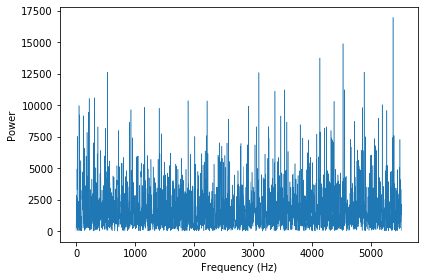

In [ ]:
spectrum.plot_power(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

`Spectrum` provides a method that computes the IntegratedSpectrum:

        def make_integrated_spectrum(self):
            cs = np.cumsum(self.power)
            cs /= cs[-1]
            return IntegratedSpectrum(cs, self.fs)

`self.power` is a NumPy array containing power for each frequency.
`np.cumsum` computes the cumulative sum of the powers. Dividing through
by the last element normalizes the integrated spectrum so it runs from 0
to 1.

The result is an IntegratedSpectrum. Here is the class definition:

    class IntegratedSpectrum(object):
        def __init__(self, cs, fs):
            self.cs = cs
            self.fs = fs

Like Spectrum, IntegratedSpectrum provides `plot_power`, so we can
compute and plot the integrated spectrum like this:

        integ = spectrum.make_integrated_spectrum()
        integ.plot_power()


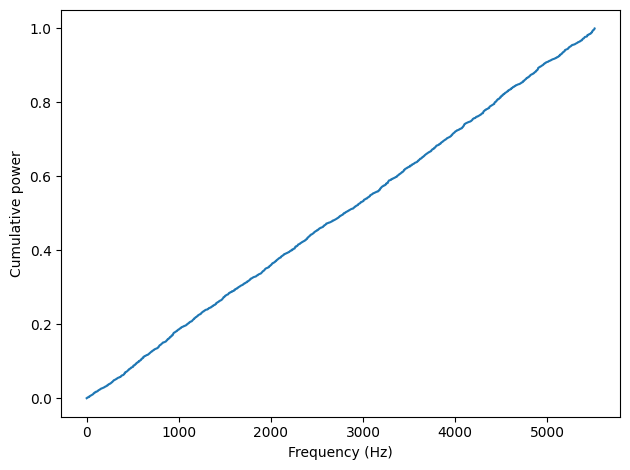

In [ ]:
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Cumulative power')

The result is a straight line, which indicates that
power at all frequencies is constant, on average. Noise with equal power
at all frequencies is called **white noise** by analogy with light,
because an equal mixture of light at all visible frequencies is white.

### Brownian noise

UU noise is uncorrelated, which means that each value does not depend on
the others. An alternative is **Brownian noise**, in which each value is
the sum of the previous value and a random "step".

It is called "Brownian" by analogy with Brownian motion, in which a
particle suspended in a fluid moves apparently at random, due to unseen
interactions with the fluid. Brownian motion is often described using a
**random walk**, which is a mathematical model of a path where the
distance between steps is characterized by a random distribution.

In [ ]:
from thinkdsp import BrownianNoise

signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

The sound is less bright, or more muffled, than white noise.

In a one-dimensional random walk, the particle moves up or down by a
random amount at each time step. The location of the particle at any
point in time is the sum of all previous steps.

This observation suggests a way to generate Brownian noise: generate
uncorrelated random steps and then add them up. Here is a class
definition that implements this algorithm:

    class BrownianNoise(_Noise):

        def evaluate(self, ts):
            dys = np.random.uniform(-1, 1, len(ts))
            ys = np.cumsum(dys)
            ys = normalize(unbias(ys), self.amp)
            return ys

`evaluate` uses `np.random.uniform` to generate an uncorrelated signal
and `np.cumsum` to compute their cumulative sum.

Since the sum is likely to escape the range from -1 to 1, we have to use
`unbias` to shift the mean to 0, and ` normalize` to get the desired
maximum amplitude.

Here's the code that generates a BrownianNoise object and plots the
waveform.

        signal = thinkdsp.BrownianNoise()
        wave = signal.make_wave(duration=0.5, framerate=11025)
        wave.plot()

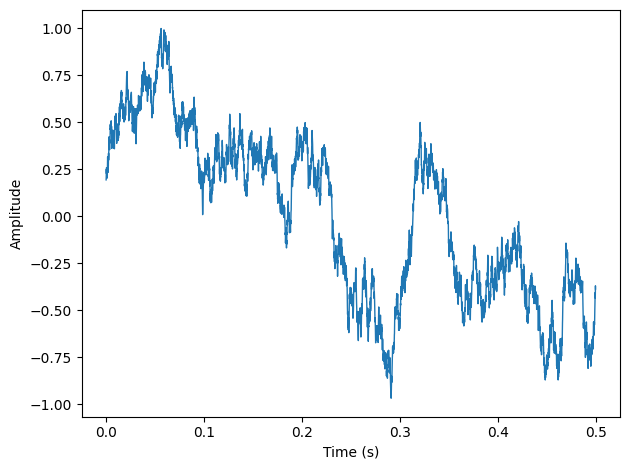

In [ ]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

The waveform wanders up and
down, but there is a clear correlation between successive values. When
the amplitude is high, it tends to stay high, and vice versa.

If you plot the spectrum of Brownian noise on a linear scaleit doesn't look like much. Nearly all
of the power is at the lowest frequencies; the higher frequency
components are not visible.

Here's what the power spectrum looks like on a linear scale.

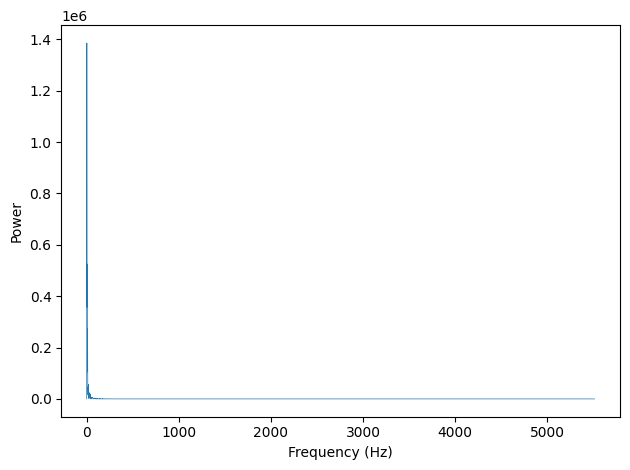

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

So much of the energy is at low frequencies, we can't even see the high frequencies.

To see the shape of the spectrum more clearly, we can plot power and
frequency on a log-log scale. Here's the code:

        import matplotlib.pyplot as plt

        spectrum = wave.make_spectrum()
        spectrum.plot_power(linewidth=1, alpha=0.5)
        plt.xscale('log')
        plt.yscale('log')


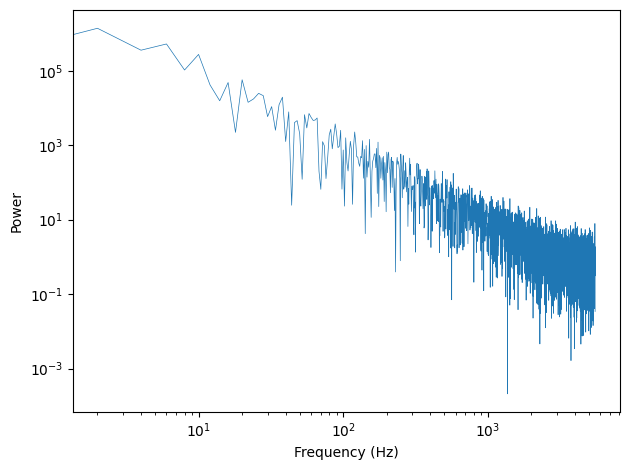

In [ ]:
# The f=0 component is very small, so on a log scale
# it's very negative.  If we clobber it before plotting,
# we can see the rest of the spectrum more clearly.
spectrum.hs[0] = 0

spectrum.plot_power(linewidth=0.5)

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

The relationship between power and
frequency is noisy, but roughly linear.

`Spectrum` provides `estimate_slope`, which uses SciPy to compute a
least squares fit to the power spectrum:

    #class Spectrum

        def estimate_slope(self):
            x = np.log(self.fs[1:])
            y = np.log(self.power[1:])
            t = scipy.stats.linregress(x,y)
            return t

It discards the first component of the spectrum because this component
corresponds to $f=0$, and $\log 0$ is undefined.

`estimate_slope` returns the result from ` scipy.stats.linregress` which
is an object that contains the estimated slope and intercept,
coefficient of determination ($R^2$), p-value, and standard error. For
our purposes, we only need the slope.

For Brownian noise, the slope of the power spectrum is -2 so
we can write this relationship: $$\log P = k -2 \log f$$ where $P$ is
power, $f$ is frequency, and $k$ is the intercept of the line, which is
not important for our purposes. Exponentiating both sides yields:
$$P = K / f^{2}$$ where $K$ is $e^k$, but still not important. More
relevant is that power is proportional to $1/f^2$, which is
characteristic of Brownian noise.

Brownian noise is also called **red noise**, for the same reason that
white noise is called "white". If you combine visible light with power
proportional to $1/f^2$, most of the power would be at the low-frequency
end of the spectrum, which is red. Brownian noise is also sometimes
called "brown noise", but I think that's confusing, so I won't use it.

In [ ]:
signal =  BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
spectrum = wave.make_spectrum()
result = spectrum.estimate_slope()
result.slope

-1.8089831662978886

The estimated slope of the line is closer to -1.8 than -2, for reasons we'll see later.

### Pink noise

For red noise, the relationship between frequency and power is
$$P = K / f^{2}$$ There is nothing special about the exponent 2. More
generally, we can synthesize noise with any exponent, $\beta$.
$$P = K / f^{\beta}$$ When $\beta = 0$, power is constant at all
frequencies, so the result is white noise. When $\beta=2$ the result is
red noise.

When $\beta$ is between 0 and 2, the result is between white and red
noise, so it is called **pink noise**.

There are several ways to generate pink noise. The simplest is to
generate white noise and then apply a low-pass filter with the desired
exponent. `thinkdsp` provides a class that represents a pink noise
signal:

    class PinkNoise(_Noise):

        def __init__(self, amp=1.0, beta=1.0):
            self.amp = amp
            self.beta = beta

`amp` is the desired amplitude of the signal. `beta` is the desired
exponent. `PinkNoise` provides `make_wave`, which generates a Wave.

        def make_wave(self, duration=1, start=0, framerate=11025):
            signal = UncorrelatedUniformNoise()
            wave = signal.make_wave(duration, start, framerate)
            spectrum = wave.make_spectrum()

            spectrum.pink_filter(beta=self.beta)

            wave2 = spectrum.make_wave()
            wave2.unbias()
            wave2.normalize(self.amp)
            return wave2

`duration` is the length of the wave in seconds. `start` is the start
time of the wave; it is included so that `make_wave` has the same
interface for all types of signal, but for random noise, start time is
irrelevant. And `framerate` is the number of samples per second.

With $\beta=0$, we get white noise:

In [ ]:
from thinkdsp import PinkNoise

signal = PinkNoise(beta=0)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

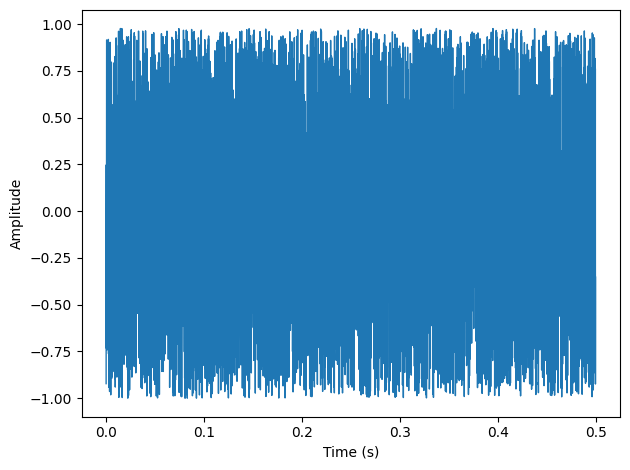

In [ ]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

With $\beta=1$, pink noise has the relationship $P = K / f$, which is why it is also called $1/f$ noise.

In [ ]:
signal = PinkNoise(beta=1)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

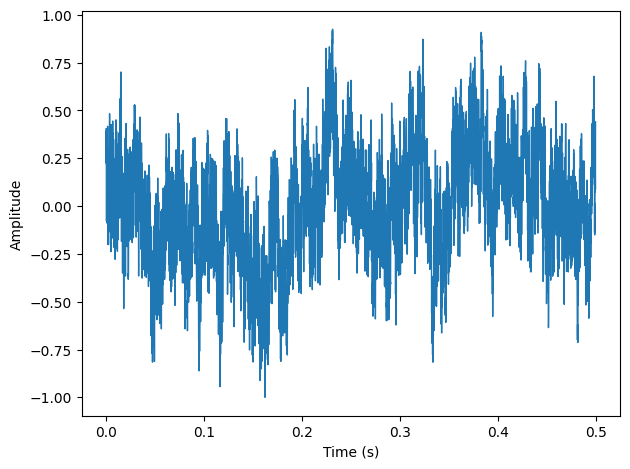

In [ ]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

With $\beta=2$, we get Brownian (aka red) noise.

In [ ]:
signal = PinkNoise(beta=2)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

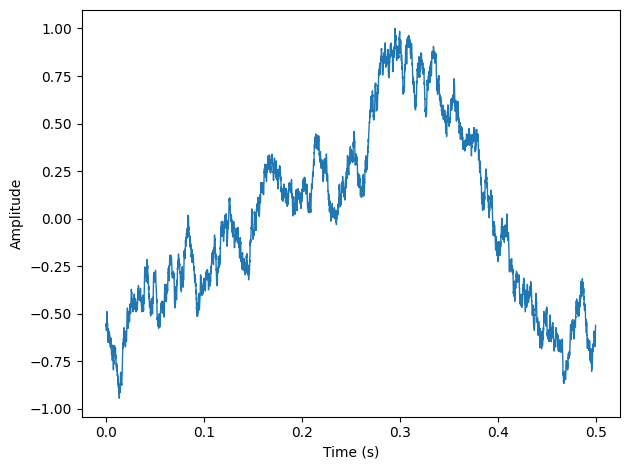

In [ ]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

How we make different noise: `make_wave` creates a white noise wave, computes its spectrum, applies a
filter with the desired exponent, and then converts the filtered
spectrum back to a wave. Then it unbiases and normalizes the wave.

`Spectrum` provides `pink_filter`:

        def pink_filter(self, beta=1.0):
            denom = self.fs ** (beta/2.0)
            denom[0] = 1
            self.hs /= denom

`pink_filter` divides each element of the spectrum by $f^{\beta/2}$.
Since power is the square of amplitude, this operation divides the power
at each component by $f^\beta$. It treats the component at $f=0$ as a
special case, partly to avoid dividing by 0, and partly because this
element represents the bias of the signal, which we are going to set to
0 anyway.

The following figure shows the power spectrums for white, pink, and red noise on a log-log scale.

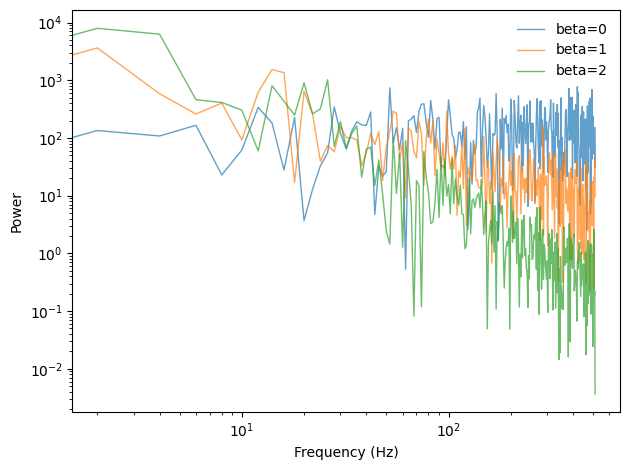

In [ ]:
betas = [0, 1, 2]

for beta in betas:
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=0.5, framerate=1024)
    spectrum = wave.make_spectrum()
    spectrum.hs[0] = 0
    label = f'beta={beta}'
    spectrum.plot_power(linewidth=1, alpha=0.7, label=label)
    
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

### Uncorrelated Gaussian noise

## Gaussian noise

We started with uncorrelated uniform (UU) noise and showed that, because
its spectrum has equal power at all frequencies, on average, UU noise is
white.

But when people talk about "white noise", they don't always mean UU
noise. In fact, more often they mean uncorrelated Gaussian (UG) noise.

`thinkdsp` provides an implementation of UG noise:

    class UncorrelatedGaussianNoise(_Noise):

        def evaluate(self, ts):
            ys = np.random.normal(0, self.amp, len(ts))
            return ys

`np.random.normal` returns a NumPy array of values from a Gaussian
distribution, in this case with mean 0 and standard deviation
`self.amp`. In theory the range of values is from negative to positive
infinity, but we expect about 99% of the values to be between -3 and 3.

UG noise is similar in many ways to UU noise. The spectrum has equal
power at all frequencies, on average, so UG is also white. And it has
one other interesting property: the spectrum of UG noise is also UG
noise. More precisely, the real and imaginary parts of the spectrum are
uncorrelated Gaussian values.


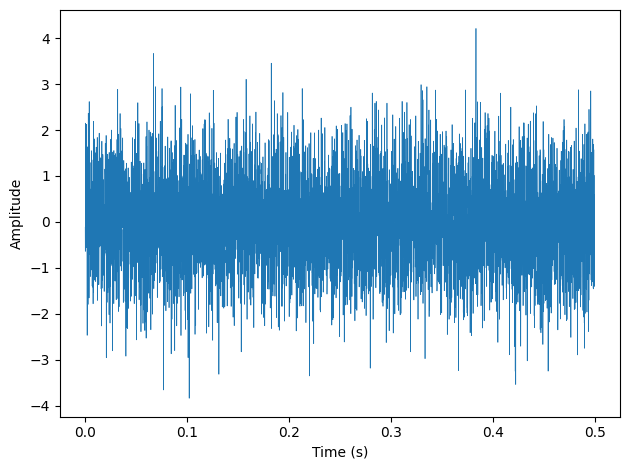

In [ ]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.plot(linewidth=0.5)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

To test that claim, we can generate the spectrum of UG noise and then
generate a "normal probability plot", which is a graphical way to test
whether a distribution is Gaussian.

        signal = thinkdsp.UncorrelatedGaussianNoise()
        wave = signal.make_wave(duration=0.5, framerate=11025)
        spectrum = wave.make_spectrum()

        thinkstats2.NormalProbabilityPlot(spectrum.real)
        thinkstats2.NormalProbabilityPlot(spectrum.imag)

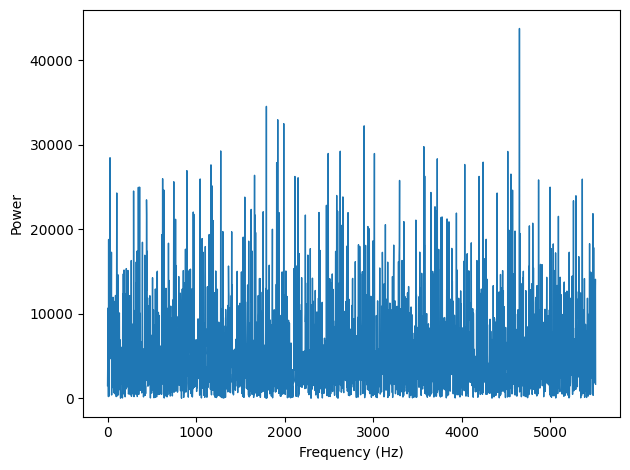

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=1)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

We can use a normal probability plot to test the distribution of the power spectrum.

In [ ]:
def normal_prob_plot(sample, fit_color='0.8', **options):
    """Makes a normal probability plot with a fitted line.

    sample: sequence of numbers
    fit_color: color string for the fitted line
    options: passed along to Plot
    """
    n = len(sample)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    
    ys = np.sort(sample)
    
    mean, std = np.mean(sample), np.std(sample)
    fit_ys = mean + std * xs
    plt.plot(xs, fit_ys, color='gray', alpha=0.5, label='model')

    plt.plot(xs, ys, **options)

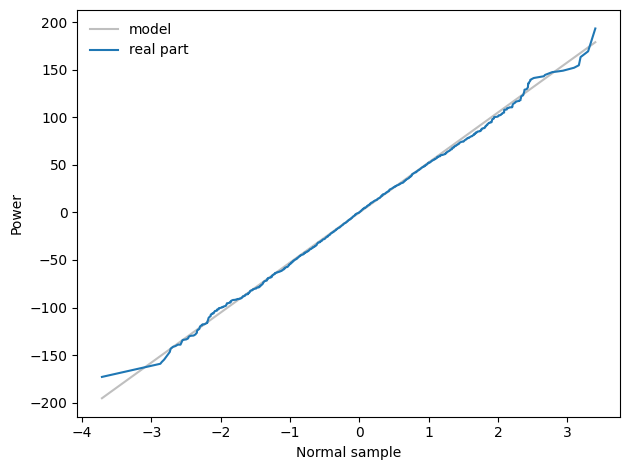

In [ ]:
normal_prob_plot(spectrum.real, color='C0', label='real part')
decorate(xlabel='Normal sample',
         ylabel='Power')

The gray lines show a linear model fit to the data;
the dark lines show the data.

A straight line on a normal probability plot indicates that the data
come from a Gaussian distribution. Except for some random variation at
the extremes, these lines are straight, which indicates that the
spectrum of UG noise is UG noise.

The spectrum of UU noise is also UG noise, at least approximately. In
fact, by the Central Limit Theorem, the spectrum of almost any
uncorrelated noise is approximately Gaussian, as long as the
distribution has finite mean and standard deviation, and the number of
samples is large.

## Exercises part 2

**Exercise 1**. *"A Soft Murmur" is a web site that plays a mixture of
natural noise sources, including rain, waves, wind, etc. At
<http://asoftmurmur.com/about/> you can find their list of recordings,
most of which are at <http://freesound.org>.*

*Download a few of these files and compute the spectrum of each signal.
Does the power spectrum look like white noise, pink noise, or Brownian
noise? How does the spectrum vary over time?*

**Exercise 2**. *In a noise signal, the mixture of frequencies changes
over time. In the long run, we expect the power at all frequencies to be
equal, but in any sample, the power at each frequency is random.*

*To estimate the long-term average power at each frequency, we can break
a long signal into segments, compute the power spectrum for each
segment, and then compute the average across the segments. You can read
more about this algorithm at
<http://en.wikipedia.org/wiki/Bartlett's_method>.*

*Implement Bartlett's method and use it to estimate the power spectrum
for a noise wave. Hint: look at the implementation of
`make_spectrogram`.*

**Exercise 3**. *At <http://www.coindesk.com> you can download the
daily price of a BitCoin as a CSV file. Read this file and compute the
spectrum of BitCoin prices as a function of time. Does it resemble
white, pink, or Brownian noise?*

**Exercise 4**. *A Geiger counter is a device that detects radiation.
When an ionizing particle strikes the detector, it outputs a surge of
current. The total output at a point in time can be modeled as
uncorrelated Poisson (UP) noise, where each sample is a random quantity
from a Poisson distribution, which corresponds to the number of
particles detected during an interval.*

*Write a class called `UncorrelatedPoissonNoise` that inherits from
`thinkdsp._Noise` and provides `evaluate`. It should use
`np.random.poisson` to generate random values from a Poisson
distribution. The parameter of this function, `lam`, is the average
number of particles during each interval. You can use the attribute
`amp` to specify `lam`. For example, if the framerate is 10 kHz and
`amp` is 0.001, we expect about 10 "clicks" per second.*

*Generate about a second of UP noise and listen to it. For low values of
`amp`, like 0.001, it should sound like a Geiger counter. For higher
values it should sound like white noise. Compute and plot the power
spectrum to see whether it looks like white noise.*

**Exercise 5**. *The algorithm in this chapter for generating pink
noise is conceptually simple but computationally expensive. There are
more efficient alternatives, like the Voss-McCartney algorithm. Research
this method, implement it, compute the spectrum of the result, and
confirm that it has the desired relationship between power and
frequency.*

